In [26]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm,skew
import ast
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder
from scipy.special import boxcox1p,inv_boxcox1p,boxcox
from sklearn.model_selection import cross_val_score
import xgboost as xgb
#import catboost as cat
import lightgbm as lgb
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
from sklearn.metrics import mean_squared_log_error




In [27]:

train_data = pd.read_csv('tmdb_data/train.csv')
test_data = pd.read_csv('tmdb_data/test.csv')
print("Shape of train set = {}, shape of test set = {}".format(train_data.shape,test_data.shape))
train_data.info()

Shape of train set = (3000, 23), shape of test set = (4398, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   objec

In [28]:
test_data.index=test_data.index+3000

df=pd.concat([train_data.drop("revenue",axis=1),test_data]).drop("id", axis=1)
y_train=train_data["revenue"]
print("Shape of df = {}, shape of y_train = {}".format(df.shape,y_train.shape))

Shape of df = (7398, 21), shape of y_train = (3000,)


C:\Users\Daniel Krasovski\.virtualenvs\IAI_Krasovski_Ofeimu-YEpp64-M\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


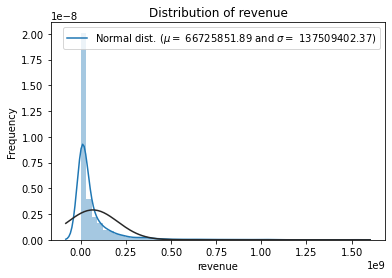

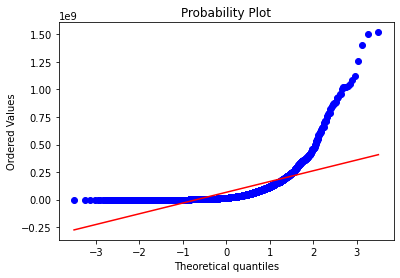

In [29]:
def visualize_distribution(y):
    sns.distplot(y,fit=norm)
    mu,sigma=norm.fit(y)
    plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu,sigma)])
    plt.title("Distribution of revenue")
    plt.ylabel("Frequency")
    plt.show()


def visualize_probplot(y):
    stats.probplot(y,plot=plt)
    plt.show()

visualize_distribution(y_train)
visualize_probplot(y_train)

C:\Users\Daniel Krasovski\.virtualenvs\IAI_Krasovski_Ofeimu-YEpp64-M\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


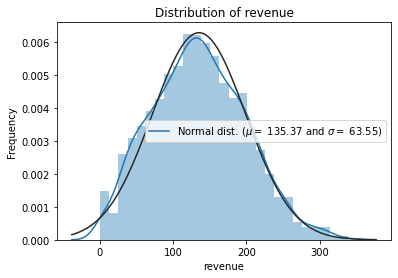

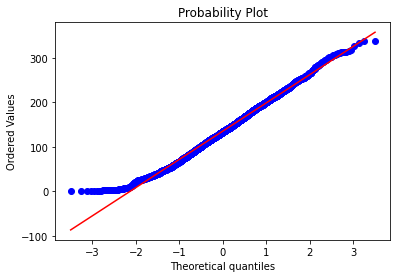

In [30]:
y_train=boxcox1p(y_train,0.2)
visualize_distribution(y_train)
visualize_probplot(y_train)

In [31]:
features_to_fix=["belongs_to_collection", "genres", "production_companies", "production_countries",\
                 "Keywords"]

for feature in features_to_fix:
    df.loc[df[feature].notnull(),feature]=\
    df.loc[df[feature].notnull(),feature].apply(lambda x : ast.literal_eval(x))\
    .apply(lambda x : [y["name"] for y in x])


df.loc[df["cast"].notnull(),"cast"]=df.loc[df["cast"].notnull(),"cast"].apply(lambda x : ast.literal_eval(x))
df.loc[df["crew"].notnull(),"crew"]=df.loc[df["crew"].notnull(),"crew"].apply(lambda x : ast.literal_eval(x))

In [32]:
df["cast_len"] = df.loc[df["cast"].notnull(),"cast"].apply(lambda x : len(x))
df["crew_len"] = df.loc[df["crew"].notnull(),"crew"].apply(lambda x : len(x))

df["production_companies_len"]=df.loc[df["production_companies"].notnull(),"production_companies"]\
.apply(lambda x : len(x))

df["production_countries_len"]=df.loc[df["production_countries"].notnull(),"production_countries"]\
.apply(lambda x : len(x))

df["Keywords_len"]=df.loc[df["Keywords"].notnull(),"Keywords"].apply(lambda x : len(x))
df["genres_len"]=df.loc[df["genres"].notnull(),"genres"].apply(lambda x : len(x))

df['original_title_letter_count'] = df['original_title'].str.len()
df['original_title_word_count'] = df['original_title'].str.split().str.len()
df['title_word_count'] = df['title'].str.split().str.len()
df['overview_word_count'] = df['overview'].str.split().str.len()
df['tagline_word_count'] = df['tagline'].str.split().str.len()

df.loc[df["homepage"].notnull(),"homepage"]=1
df["homepage"]=df["homepage"].fillna(0)  # Note that we only need to know if the film has a webpage or not!

df["in_collection"]=1
df.loc[df["belongs_to_collection"].isnull(),"in_collection"]=0

df["has_tagline"]=1
df.loc[df["tagline"].isnull(),"has_tagline"]=0

df["title_different"]=1
df.loc[df["title"]==df["original_title"],"title_different"]=0

df["isReleased"]=1
df.loc[df["status"]!="Released","isReleased"]=0

release_date=pd.to_datetime(df["release_date"])
df["release_year"]=release_date.dt.year
df["release_month"]=release_date.dt.month
df["release_day"]=release_date.dt.day
df["release_wd"]=release_date.dt.dayofweek
df["release_quarter"]=release_date.dt.quarter

df.loc[df["cast"].notnull(),"cast"]=df.loc[df["cast"].notnull(),"cast"]\
.apply(lambda x : [y["name"] for y in x if y["order"]<6])

df["Director"]=[[] for i in range(df.shape[0])]
df["Producer"]=[[] for i in range(df.shape[0])]
df["Executive Producer"]=[[] for i in range(df.shape[0])]

df["Director"]=df.loc[df["crew"].notnull(),"crew"]\
.apply(lambda x : [y["name"] for y in x if y["job"]=="Director"])

df["Producer"]=df.loc[df["crew"].notnull(),"crew"]\
.apply(lambda x : [y["name"] for y in x if y["job"]=="Producer"])

df["Executive Producer"]=df.loc[df["crew"].notnull(),"crew"]\
.apply(lambda x : [y["name"] for y in x if y["job"]=="Executive Producer"])

df=df.drop(["imdb_id","original_title","overview","poster_path","tagline","status","title",\
           "spoken_languages","release_date","crew"],axis=1)

In [33]:
mis_val=((df.isnull().sum()/df.shape[0])*100).sort_values(ascending=False)
mis_val=mis_val.drop(mis_val[mis_val==0].index)
print(mis_val)

to_empty_list=["belongs_to_collection","Keywords","production_companies","production_countries",\
              "Director","Producer","Executive Producer","cast","genres"]

for feature in to_empty_list:
    df[feature] = df[feature].apply(lambda d: d if isinstance(d, list) else [])

to_zero=["runtime","release_month","release_year","release_wd","release_quarter","release_day"]+\
["Keywords_len","production_companies_len","production_countries_len","crew_len","cast_len","genres_len",
    "tagline_word_count","overview_word_count","title_word_count"]

for feat in to_zero:
    df[feat]=df[feat].fillna(0)

df['_budget_popularity_ratio'] = df['budget']/df['popularity']
df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']

mis_val=((df.isnull().sum()/df.shape[0])*100).sort_values(ascending=False)
mis_val=mis_val.drop(mis_val[mis_val==0].index)
print(mis_val)

belongs_to_collection       79.981076
tagline_word_count          19.735064
Keywords                     9.042985
Keywords_len                 9.042985
production_companies         5.596107
production_companies_len     5.596107
production_countries         2.122195
production_countries_len     2.122195
crew_len                     0.513652
Producer                     0.513652
Executive Producer           0.513652
Director                     0.513652
cast_len                     0.351446
cast                         0.351446
genres                       0.310895
genres_len                   0.310895
overview_word_count          0.297378
runtime                      0.081103
title_word_count             0.040552
release_year                 0.013517
release_month                0.013517
release_day                  0.013517
release_wd                   0.013517
release_quarter              0.013517
dtype: float64
Series([], dtype: float64)


_budget_popularity_ratio         85.779254
_releaseYear_popularity_ratio    60.793692
popularity                       19.960329
Keywords_len                      3.123832
production_countries_len          2.990402
budget                            2.891855
cast_len                          2.809725
dtype: float64
_budget_popularity_ratio        -0.881118
_releaseYear_popularity_ratio    2.603587
popularity                      -0.437615
Keywords_len                    -0.309683
production_countries_len         1.332405
budget                          -0.476944
cast_len                         0.220478
dtype: float64
The final total number of features is 1571
The shape of train DataFrame is (3000, 1571) and the shape of the test DataFrame is (4398, 1571)


C:\Users\Daniel Krasovski\.virtualenvs\IAI_Krasovski_Ofeimu-YEpp64-M\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
C:\Users\Daniel Krasovski\.virtualenvs\IAI_Krasovski_Ofeimu-YEpp64-M\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Daniel Krasovski\.virtualenvs\IAI_Krasovski_Ofeimu-YEpp64-M\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.

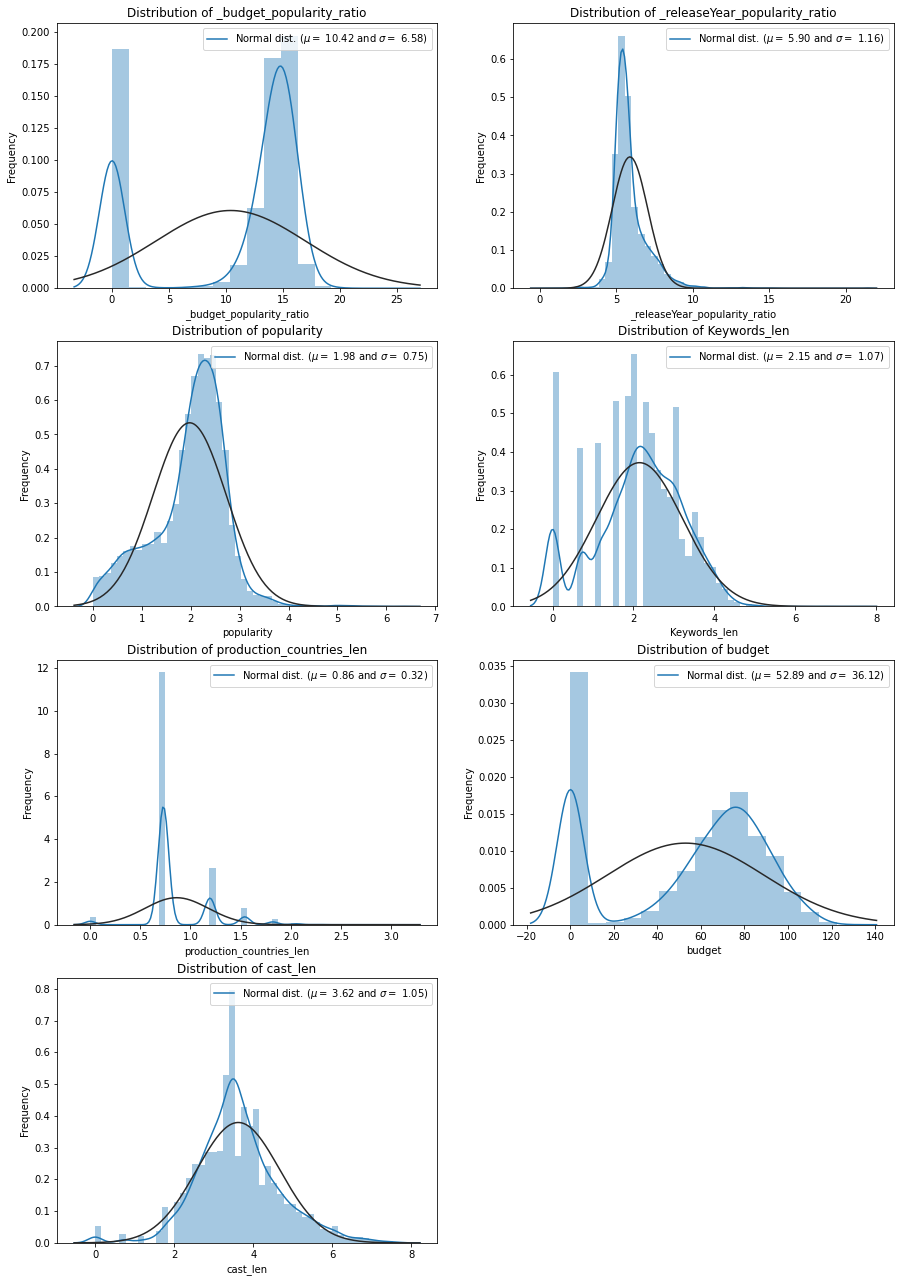

In [34]:
numeric=[feat for feat in df.columns if df[feat].dtype!="object"]

skewness=df[numeric].apply(lambda x : skew(x)).sort_values(ascending=False)
skew=skewness[skewness>2.5]
print(skew)

high_skew=skew[skew>10].index
medium_skew=skew[skew<=10].index

for feat in high_skew:
    df[feat]=np.log1p(df[feat])

for feat in medium_skew:
    df[feat]=df[feat]=boxcox1p(df[feat],0.15)


skew=df[skew.index].skew()
print(skew)

plt.figure(figsize=(15,40))
for i,feat in enumerate(skew.index):
    plt.subplot(7,2,i+1)
    sns.distplot(df[feat],fit=norm)
    mu,sigma=norm.fit(df[feat])
    plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu,sigma)])
    plt.title("Distribution of "+feat)
    plt.ylabel("Frequency")
plt.show()

lbl=LabelEncoder()
lbl.fit(df["release_year"].values)
df["release_year"]=lbl.transform(df["release_year"].values)

to_dummy = ["belongs_to_collection","genres","original_language","production_companies","production_countries",\
           "Keywords","cast","Director","Producer","Executive Producer"]

limits=[4,0,0,35,10,40,10,5,10,12]

for i,feat in enumerate(to_dummy):
    mlb = MultiLabelBinarizer()
    s=df[feat]
    x=pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)
    y=pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index).sum().sort_values(ascending=False)
    rare_entries=y[y<=limits[i]].index
    x=x.drop(rare_entries,axis=1)
    df=df.drop(feat,axis=1)
    df=pd.concat([df, x], axis=1, sort=False)

print("The final total number of features is {}".format(df.shape[1]))
ntrain=train_data.shape[0]

train=df.iloc[:ntrain,:]
test=df.iloc[ntrain:,:]
print("The shape of train DataFrame is {} and the shape of the test DataFrame is {}".format(train.shape,test.shape))

In [35]:
model_xgb=xgb.XGBRegressor(max_depth=5,
                           learning_rate=0.1,
                           n_estimators=2000,
                           objective='reg:linear',
                           gamma=1.45,
                           verbosity=3,
                           subsample=0.7,
                           colsample_bytree=0.8,
                           colsample_bylevel=0.50)

model_lgb=lgb.LGBMRegressor(n_estimators=10000,
                             objective="regression",
                             metric="rmse",
                             num_leaves=20,
                             min_child_samples=100,
                             learning_rate=0.01,
                             bagging_fraction=0.8,
                             feature_fraction=0.8,
                             bagging_frequency=1,
                             subsample=.9,
                             colsample_bytree=.9,
                             use_best_model=True)

# model_cat = cat.CatBoostRegressor(iterations=10000,learning_rate=0.01,depth=5,eval_metric='RMSE',\
#                               colsample_bylevel=0.7,
#                               bagging_temperature = 0.2,
#                               metric_period = None,
#                               early_stopping_rounds=200)

[12:31:29] ======== Monitor: Learner ========
[12:31:29] Configure: 0.000482s, 1 calls @ 482us

[12:31:29] ======== Monitor: GBTree ========
[12:31:29] ======== Monitor: TreePruner ========


In [36]:
n_folds=5

def cross_val(model):
    cr_val=np.sqrt(-cross_val_score(model,train.values,y_train.values,scoring="neg_mean_squared_log_error",cv=5))
    return cr_val


In [37]:
def msle(y,y_pred):
    return np.sqrt(mean_squared_log_error(y,y_pred))

ti=time.time()
model_lgb.fit(train.values,y_train)
print("Number of minutes of training of model_lgb = {:.2f}".format((time.time()-ti)/60))

lgb_pred_train=model_lgb.predict(train.values)
print("Mean square logarithmic error of lgb model on whole train = {:.4f}".format(msle(y_train,lgb_pred_train)))

ti=time.time()
model_xgb.fit(train.values,y_train)
print("Number of minutes of training of model_xgb = {:.2f}".format((time.time()-ti)/60))

xgb_pred_train=model_xgb.predict(train.values)
print("Mean square logarithmic error of xgb model on whole train = {:.4f}".format(msle(y_train,xgb_pred_train)))

ti=time.time()
#model_cat.fit(train.values,y_train,verbose=False)
print("Number of minutes of training of model_cal = {:.2f}".format((time.time()-ti)/60))

#cat_pred_train=model_cat.predict(train.values)
#cat_pred_train[cat_pred_train<0]=0
#print("Mean square logarithmic error of cat model on whole train = {:.4f}".format(msle(y_train,cat_pred_train)))

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] Unknown parameter: use_best_model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
Number of minutes of training of model_lgb = 0.38
Mean square logarithmic error of lgb model on whole train = 0.2038
[12:31:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[12:31:54] DEBUG: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\gbm\gbtree.cc:147: Using tree method: 2
[12:31:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:31:54] INFO: C:\Users\Administrator\workspace\xgboost-

The sum of the entries of c is 1.0
Mean square logarithmic error of chosen model on whole train = 0.4068


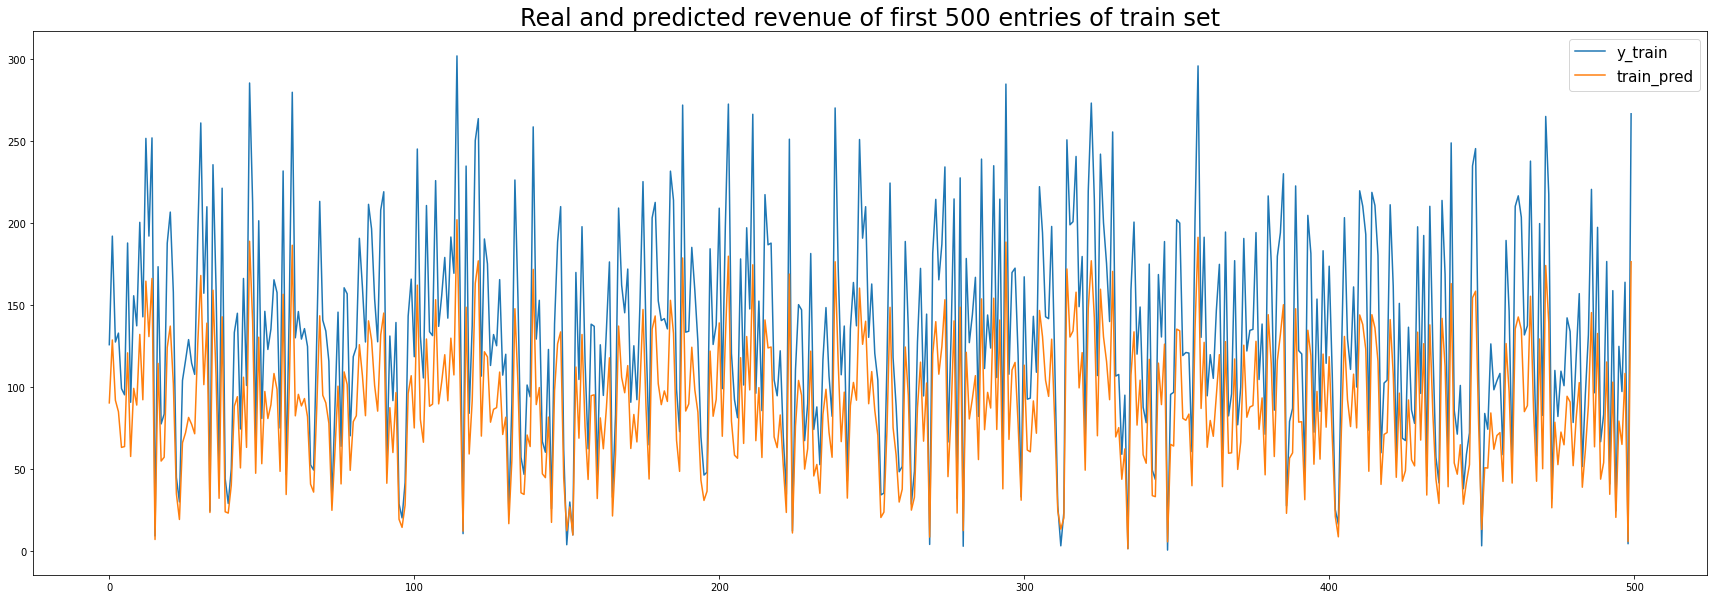

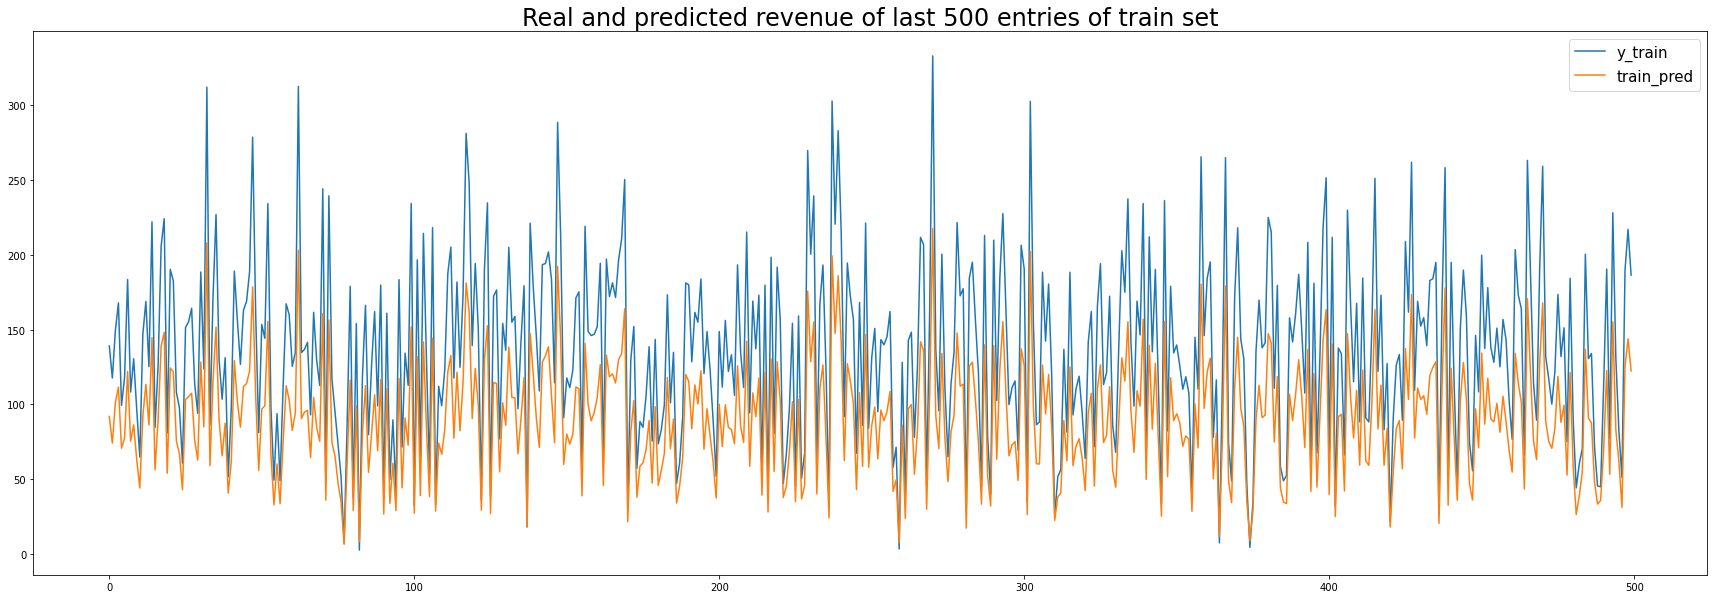

In [38]:
c = np.array([0.333334,0.333333,0.333333])

print("The sum of the entries of c is {}".format(c.sum()))

train_pred=xgb_pred_train*c[0]+lgb_pred_train*c[1]#+cat_pred_train*c[2]
print("Mean square logarithmic error of chosen model on whole train = {:.4f}".format(msle(y_train,train_pred)))

plt.figure(figsize=(30,10))
plt.plot(y_train[:500],label="y_train")
plt.plot(train_pred[:500],label="train_pred")
plt.legend(fontsize=15)
plt.title("Real and predicted revenue of first 500 entries of train set",fontsize=24)
plt.show()

plt.figure(figsize=(30,10))
plt.plot(y_train.values[-500:],label="y_train")
plt.plot(train_pred[-500:],label="train_pred")
plt.legend(fontsize=15)
plt.title("Real and predicted revenue of last 500 entries of train set",fontsize=24)
plt.show()

In [39]:
lgb_pred=model_lgb.predict(test)
xgb_pred=model_xgb.predict(test.values)
#cat_pred=model_cat.predict(test)

pred=inv_boxcox1p((xgb_pred*c[0]+lgb_pred*c[1]),0.2)

sub=pd.DataFrame({"id":np.arange(test.shape[0])+3001,"revenue":pred})
sub.to_csv("my_submission.csv",index=False)